In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from skimage.filters import unsharp_mask

/home/uiu/miniconda3/envs/tf_conda/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-27 14:57:21.609115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
torch.cuda.is_available()

False

In [9]:
# tf.sysconfig.get_build_info()

In [10]:
def apply_mask(aseg_image, brain_image, labels = [17, 53, 2, 7, 41, 46]):
    brain_data = brain_image.get_fdata()
    aseg_data = aseg_image.get_fdata()
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

    segmented_brain_image = brain_data * brain_mask
    segmented_brain_image = nibabel.Nifti1Image(segmented_brain_image, affine=None)

    return segmented_brain_image

def resize_image(img_data, size):
    resized_img_data = torch.nn.functional.interpolate(
        torch.unsqueeze(torch.unsqueeze(torch.tensor(img_data), 0), 0),
        size=size, # H x W x D
        mode='trilinear',
        align_corners=False,
    )
    return resized_img_data.squeeze().numpy()

def crop(image_data, margin = 30):
  #cropping a image by 30 from each side
    crop_margin = margin
    img_shape = image_data.shape
    crop_start = (crop_margin, crop_margin, 0)
    crop_end = (img_shape[0] - crop_margin, img_shape[1] - crop_margin, img_shape[2])
    cropped_image = image_data[crop_start[0]:crop_end[0], crop_start[1]:crop_end[1], crop_start[2]:crop_end[2]]

    return cropped_image

def enhance_slice(slice_data):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_slice = clahe.apply(slice_data.astype(np.uint8))

    return enhanced_slice

def enhance_image(img_data):
    enhanced_slices = []
    
    for slice_idx in range(img_data.shape[2]):
        slice_data = img_data[:, :, slice_idx]
        enhanced_slice = enhance_slice(slice_data)
        enhanced_slices.append(enhanced_slice)
    enhanced_volume = np.dstack(enhanced_slices)

    return enhanced_volume

def sharpen_image(image, strength=1.0):
    sharpened_image = unsharp_mask(image, radius=1, amount=strength)
    return sharpened_image

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
import six
from math import ceil
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten
from tensorflow.keras.layers import Conv3D, AveragePooling3D, MaxPooling3D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block (by @raghakot)."""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """Helper to build a  BN -> relu -> conv3d block."""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(activation)

    return f


def _shortcut3d(input, residual):
    """3D shortcut to match input and residual and merges them with "sum"."""
    stride_dim1 = ceil(input.shape[DIM1_AXIS] / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal",
            padding="valid",
            kernel_regularizer=l2(1e-4),
        )(input)
    return add([shortcut, residual])


def _residual_block3d(
    block_function, filters, kernel_regularizer, repetitions, is_first_layer=False
):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(
                filters=filters,
                strides=strides,
                kernel_regularizer=kernel_regularizer,
                is_first_block_of_first_layer=(is_first_layer and i == 0),
            )(input)
        return input

    return f


def basic_block(
    filters,
    strides=(1, 1, 1),
    kernel_regularizer=l2(1e-4),
    is_first_block_of_first_layer=False,
):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""

    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(
                filters=filters,
                kernel_size=(3, 3, 3),
                strides=strides,
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer,
            )(input)
        else:
            conv1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(3, 3, 3),
                strides=strides,
                kernel_regularizer=kernel_regularizer,
            )(input)

        residual = _bn_relu_conv3d(
            filters=filters,
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer,
        )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(
    filters,
    strides=(1, 1, 1),
    kernel_regularizer=l2(1e-4),
    is_first_block_of_first_layer=False,
):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""

    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(
                filters=filters,
                kernel_size=(1, 1, 1),
                strides=strides,
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer,
            )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(1, 1, 1),
                strides=strides,
                kernel_regularizer=kernel_regularizer,
            )(input)

        conv_3_3 = _bn_relu_conv3d(
            filters=filters,
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer,
        )(conv_1_1)
        residual = _bn_relu_conv3d(
            filters=filters * 4,
            kernel_size=(1, 1, 1),
            kernel_regularizer=kernel_regularizer,
        )(conv_3_3)

        return _shortcut3d(input, residual)

    return f


def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == "channels_last":
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError("Invalid {}".format(identifier))
        return res
    return identifier


class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """Instantiate a vanilla ResNet3D keras model.

        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError(
                "Input shape should be a tuple "
                "(conv_dim1, conv_dim2, conv_dim3, channels) "
                "for tensorflow as backend or "
                "(channels, conv_dim1, conv_dim2, conv_dim3) "
                "for theano as backend"
            )

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(
            filters=64,
            kernel_size=(7, 7, 7),
            strides=(2, 2, 2),
            kernel_regularizer=l2(reg_factor),
        )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding="same")(
            conv1
        )

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(
                block_fn,
                filters=filters,
                kernel_regularizer=l2(reg_factor),
                repetitions=r,
                is_first_layer=(i == 0),
            )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(
            pool_size=(
                block.shape[DIM1_AXIS],
                block.shape[DIM2_AXIS],
                block.shape[DIM3_AXIS],
            ),
            strides=(1, 1, 1),
        )(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="softmax",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)
        else:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="sigmoid",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 18."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [2, 2, 2, 2], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_34(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 34."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [3, 4, 6, 3], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_50(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 50."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, bottleneck, [3, 4, 6, 3], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_101(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 101."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, bottleneck, [3, 4, 23, 3], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_152(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 152."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, bottleneck, [3, 8, 36, 3], reg_factor=reg_factor
        )


In [12]:
csv_path = "adni-1-5t-filtered-preprocessed-quickseg-dataset/ADNI_1p5T_Filtered.csv"
base = "adni-1-5t-filtered-preprocessed-quickseg-dataset"
mri_images = os.listdir(os.path.join(base, "AD"))
for i in os.listdir(os.path.join(base, "CN")):
    mri_images.append(i)
for i in os.listdir(os.path.join(base, "MCI")):
    mri_images.append(i)
    
csv_data = pd.read_csv(csv_path)
df = pd.DataFrame(csv_data)

In [13]:
mci_data = df[df['Group'] == 'MCI']
ad_data = df[df['Group'] == 'AD']
cn_data = df[df['Group'] == 'CN']

max_len = max(len(mci_data), len(ad_data), len(cn_data))

In [14]:
len(mci_data), len(ad_data), len(cn_data)

(316, 133, 196)

In [15]:
from sklearn.utils import resample

mci_data_resampled = resample(mci_data, replace=True, n_samples=max_len, random_state=42)
ad_data_resampled = resample(ad_data, replace=True, n_samples=max_len, random_state=42)
cn_data_resampled = resample(cn_data, replace=True, n_samples=max_len, random_state=42)

In [16]:
balanced_df = pd.concat([mci_data_resampled, ad_data_resampled, cn_data_resampled])

In [17]:
len(balanced_df[balanced_df["Group"] == "AD"]), len(balanced_df[balanced_df["Group"] == "CN"]), len(balanced_df[balanced_df["Group"] == "MCI"])

(316, 316, 316)

In [18]:
len(balanced_df)

948

In [22]:
balanced_df[balanced_df['Group']=="CN"].to_csv("cn.csv", index=False)

In [19]:
balanced_df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
235,I118698,007_S_0414,MCI,F,80,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,5/22/2006,NiFTI,3/03/2022
403,I31084,023_S_0042,MCI,M,73,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,10/31/2005,NiFTI,3/03/2022
239,I35734,007_S_0041,MCI,F,71,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,10/21/2005,NiFTI,3/03/2022
204,I79627,041_S_1420,MCI,F,82,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/24/2007,NiFTI,3/03/2022
321,I65727,068_S_0442,MCI,M,75,sc,MRI,MPR-R; ; N3; Scaled,Processed,5/09/2006,NiFTI,3/03/2022


In [17]:
from tensorflow.keras.utils import Sequence
from scipy.ndimage import rotate
from skimage.transform import resize

class Dataset(Sequence):
    def __init__(self, dataframe, dataset_type='', batch_size=32, shuffle=True, rotation_range=50):
        self.data = dataframe
        self.dataset_type = dataset_type
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.rotation_range = rotation_range
        self.le = LabelEncoder()
        self.encoded_classes = self.le.fit_transform(self.data["Group"].values)
        self.on_epoch_end()
        self.true_labels = []

    def _load_image(self, img_id, label):
        base = "adni-1-5t-filtered-preprocessed-quickseg-dataset"
        img_id = img_id + ".nii"
        subject_dir = os.path.join(base, label, img_id, "mri")
        
        aseg_image = nibabel.load(os.path.join(subject_dir, "aparc.DKTatlas+aseg.deep.mgz"))
        brain_image = nibabel.load(os.path.join(subject_dir, "aparc.DKTatlas+aseg.deep.mgz"))
        
        image = apply_mask(aseg_image, brain_image)
        image = image.get_fdata()
#         cropped_image = crop(image, margin=30)
        image = resize(image, (128,128,128), anti_aliasing=True)
        
        if self.dataset_type == 'train':
            rotation_angle = np.random.uniform(-self.rotation_range, self.rotation_range) #random angle
            rotated_image = rotate(image, rotation_angle, reshape=False) #applying random rotation to the image
            enhance = enhance_image(rotated_image) #applying clahe
            sharp = sharpen_image(enhance) #sharpening

            final_image = np.stack((sharp,) * 3, axis=3)
            return final_image
    
        final_image = np.stack((image,) * 3, axis=3)
#         final_image = torch.tensor(final_image, dtype=torch.float)
        return final_image

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_data = [self.data.iloc[i] for i in indices]

        images = []
        labels = []
        for data_row in batch_data:
            img_id = data_row.iloc[0]
            label = data_row.iloc[2]
            img = self._load_image(img_id, label)
            img = np.transpose(img, (2, 0, 1, 3))
            one_hot_label = np.eye(len(self.le.classes_))[self.le.transform([label])[0]]
            images.append(img)
            labels.append(one_hot_label)
            self.true_labels.append(one_hot_label)
        return np.asarray(images), np.asarray(labels)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [35]:
train_data, temp = train_test_split(balanced_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp, test_size=0.5, random_state=42)

train_dataset = Dataset(train_data, dataset_type='train', batch_size=20)
val_dataset = Dataset(val_data, batch_size=20)
test_dataset = Dataset(test_data, batch_size=20)

In [36]:
len(train_dataset)*20, len(val_dataset)*20, len(test_dataset)*20

(660, 140, 140)

In [20]:
for images, labels in train_dataset:
    break

(128, 128, 128, 3)


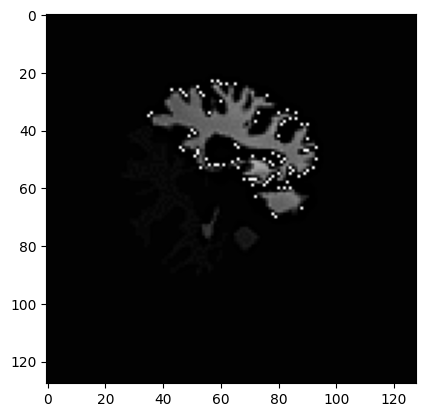

In [21]:
print(images[0].shape)
plt.imshow(images[0][49,:,:])
plt.show()

In [22]:
from tensorflow.keras.optimizers import Adam

classes = 3
image_shape = images[0].shape
print(image_shape)
model = Resnet3DBuilder.build_resnet_18(input_shape = image_shape, num_outputs=classes)

model.compile(
    optimizer=Adam(0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'Recall', 'AUC', 'Precision']
)

(128, 128, 128, 3)


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 64, 64, 64, 6 65920       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64, 6 256         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64, 6 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [24]:
num_epochs = 10
history = model.fit(train_dataset, validation_data = val_dataset, epochs=num_epochs, workers=2)

2024-03-27 03:51:39.187268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-03-27 03:51:39.204815: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/10


2024-03-27 03:51:42.431910: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-27 03:52:10.081244: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


33/33 [==============================] - 598s 18s/step - loss: 2.0856 - accuracy: 0.3308 - recall: 0.0541 - auc: 0.5021 - precision: 0.3781 - val_loss: 121.4469 - val_accuracy: 0.3571 - val_recall: 0.3571 - val_auc: 0.5179 - val_precision: 0.3571
Epoch 2/10
33/33 [==============================] - 574s 17s/step - loss: 2.0320 - accuracy: 0.3938 - recall: 0.0199 - auc: 0.5712 - precision: 0.5551 - val_loss: 23.1972 - val_accuracy: 0.3643 - val_recall: 0.3643 - val_auc: 0.5254 - val_precision: 0.3643
Epoch 3/10
33/33 [==============================] - 585s 17s/step - loss: 2.0042 - accuracy: 0.4278 - recall: 0.0144 - auc: 0.5970 - precision: 0.6556 - val_loss: 16.9415 - val_accuracy: 0.4286 - val_recall: 0.4286 - val_auc: 0.5616 - val_precision: 0.4286
Epoch 4/10
33/33 [==============================] - 586s 17s/step - loss: 1.9881 - accuracy: 0.4302 - recall: 0.0775 - auc: 0.5929 - precision: 0.4511 - val_loss: 28.7984 - val_accuracy: 0.3571 - val_recall: 0.3571 - val_auc: 0.5179 - val_

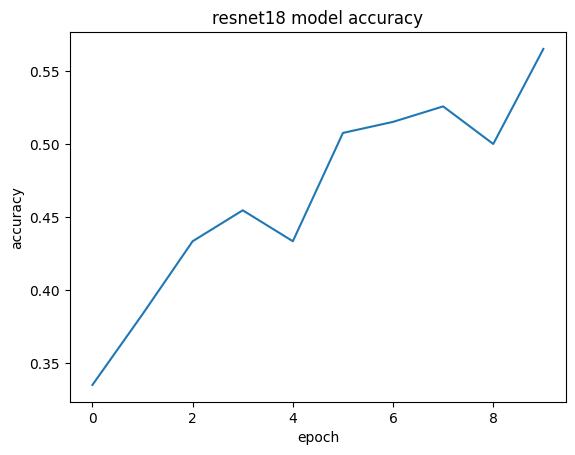

In [25]:
plt.plot(history.history['accuracy'])
plt.title('resnet18 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

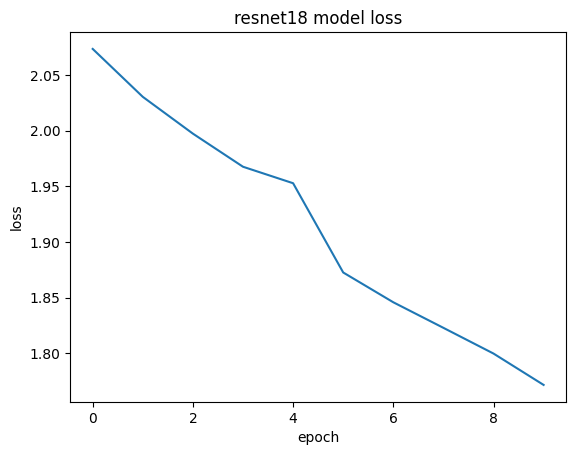

In [26]:
plt.plot(history.history['loss'])
plt.title('resnet18 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [28]:
model.save('resnet18_ROI.h5')

In [52]:
res = model.evaluate(test_dataset)

7/7 [==============================] - 131s 19s/step - loss: 264.1930 - accuracy: 0.2714 - recall: 0.2714 - auc: 0.4536 - precision: 0.2714


In [37]:
for dt in test_dataset:
    _, _ = dt

In [29]:
pred = model.predict(test_dataset)

In [38]:
true_labels = test_dataset.true_labels

In [40]:
len(pred), len(true_labels)

(140, 140)

In [44]:
pred = np.argmax(pred, axis=1)

In [46]:
true_labels = np.argmax(true_labels, axis = 1)

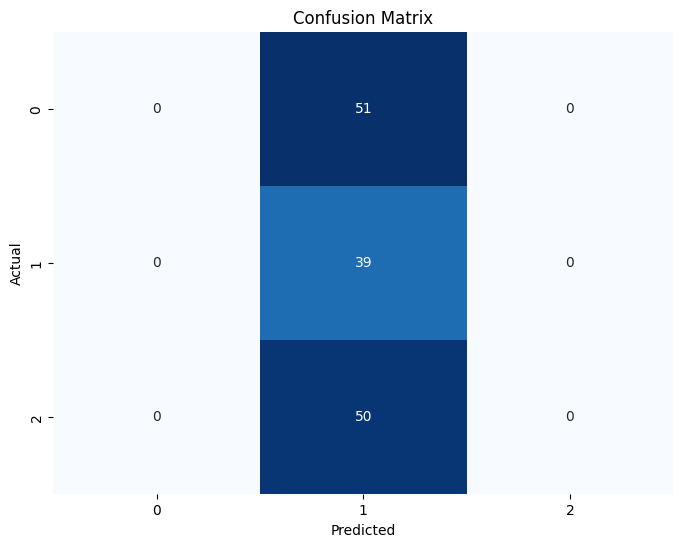

In [50]:
import seaborn as sb
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(true_labels, pred)

plt.figure(figsize=(8,6))
sb.heatmap(
    c_matrix,
    annot = True,
    cmap='Blues',
    fmt='g',
    cbar= False,
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()